# Investigation into the effect of Viscosity on gravity driven fluid oscillation in a straw

In [1]:
#importing all using libraries
import numpy as np
import scipy as sp
from ipywidgets import interact
from scipy.integrate import odeint
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline

By exporting all of the tracker data into a format of .dat, we are able to utilize and directly import the data into jupyter notebook.

In [2]:
#importing data
file_dir = './'
filename= '7924.dat'

data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,2]

timeshift = 0.267 # the time shifting varaible, shifted so that t = 0, is when the stopper is removed.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]


By plotting the data now, we are able to adjust the timeshift variable, while also providing a small window into how the data looks like.

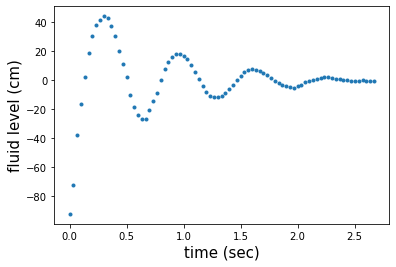

In [3]:
# plotting the raw data
plt.plot(time_data_clean[8:],z_data_clean[8:],'.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.show()

Now we would need to fill in some constants in each trial to calculate the initial condition of the fluid in the straw.

In [5]:
# calculate the initial starting level of the fluid in the submersed straw:
density = 1 # g/cm^3
atmPressure = 1030 # g/cm^2
h = 10 # cm
H = 20  # length of straw, cm
d = (1 - atmPressure/(density*h + atmPressure))*H
print('fluid level will be %2.2f cm above the bottom of the straw'%(d))

fluid level will be 0.19 cm above the bottom of the straw
